# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.datasets import cifar10
from keras.applications.resnet import preprocess_input

In [2]:
tf.__version__

'2.4.0'

In [3]:
tf.keras.__version__

'2.4.0'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4247887887191215739
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15692777408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 787793164771937267
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

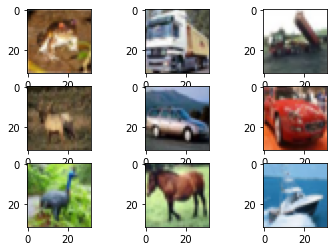

(50000, 32, 32, 3)

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)
X_train_full.shape

## Build and train the model

Build and train your model. 

In [16]:
# TODO: load the model you selected
resnet50_base=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape = (256, 256, 3),
    pooling='avg',
    classes=10
)


model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(resnet50_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))



In [17]:
# show the structure of your model
model.build(X_train_full.shape) 
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_9 (UpSampling2 (50000, 64, 64, 3)        0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (50000, 128, 128, 3)      0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (50000, 256, 256, 3)      0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_2 (Flatten)          (50000, 2048)             0         
_________________________________________________________________
batch_normalization_6 (Batch (50000, 2048)             8192      
_________________________________________________________________
dense_6 (Dense)              (50000, 128)             

In [18]:
batch_size = 32
epochs = 4


opt=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=False, name="SGD")

model.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["accuracy"])

history=model.fit(X_train_full, y_train_full, batch_size=batch_size, epochs=epochs,validation_split=0.15)

Epoch 1/4
1329/1329 [==============================] - 305s 226ms/step - loss: 1.6145 - accuracy: 0.4783 - val_loss: 0.3296 - val_accuracy: 0.9012
Epoch 2/4
1329/1329 [==============================] - 299s 225ms/step - loss: 0.5351 - accuracy: 0.8564 - val_loss: 0.2890 - val_accuracy: 0.9083
Epoch 3/4
1329/1329 [==============================] - 299s 225ms/step - loss: 0.3551 - accuracy: 0.9058 - val_loss: 0.2215 - val_accuracy: 0.9307
Epoch 4/4
1329/1329 [==============================] - 299s 225ms/step - loss: 0.2795 - accuracy: 0.9286 - val_loss: 0.1783 - val_accuracy: 0.9427


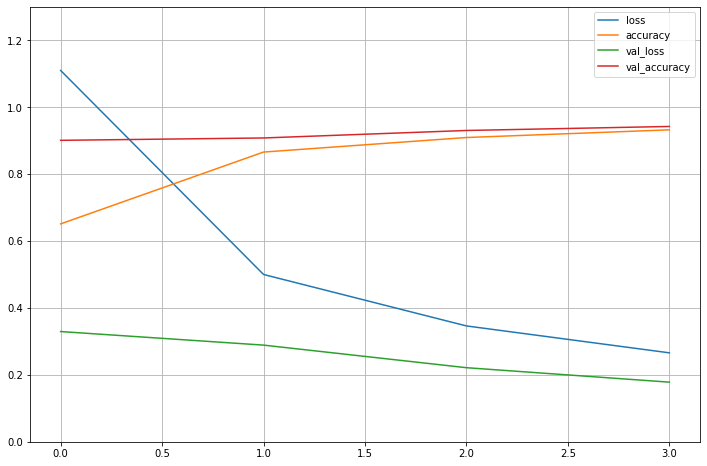

In [19]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1.3)
plt.grid(True)
plt.show()

## Save the model

In [20]:
model.save('cifar10.h5') 

## Load the model and evaluate it on the test data

In [21]:
model = keras.models.load_model("cifar10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 23s 70ms/step - loss: 0.1919 - accuracy: 0.9405


[0.1918880194425583, 0.940500020980835]

In [22]:
from google.colab import files
files.download("cifar10.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

### Model Architecture

Following the "Deep Residual Learning for Image Recognition" paper: https://arxiv.org/pdf/1512.03385.pdf :

We have used ResNet50 as our pre-trained base model for transfer learning.

#### Network:

ResNet50 is short for residual networks which is used as backbone network in many computer vision task and specially Image recognition. It has been pretrained on ImagNet dataset and performed really well for CIFAR 10. 

ResNet50 as backbone network for transfer learning  provides pretrained high level features of 2048 dimension and on top we added our own classifier of 3 dense layer which outputs 10 dimensiona logits for Cifar10 classification. 

#### Classifier Neuron and Layer selection

Most important features required for this classification is provided by the ResNet backbone. Thus we choose a small classifier with 3 layers and decrement the layer size by a factor of 2 for each layer.

After many experiments, we choose first classifer layer as 128 dimension such that we do not face overfitting and keep on decreasing it.

Classifier layer Dimensions: 2048 (from ResNet50) -> 128 -> 64 ->32

#### Optimizer and Learning rate

The most important for transfer learning is to keep the Learning rate small As good practice, learning rate for transfer learning should be 100 times smaller compared to normal learning from scratch. 
In case learning rate is kept high, then your pre-trained network parameter gets changed significanlty and the network forgets the previous knowledge from pre-training. This defeats the purpose of transfer learning

Experiment with Adam: At first we decided to train our network using Adam Optimizer with learning rate of 0.00001. It provided a test accuracy of around 82%. 

However "Deep Residual Learning for Image Recognition" paper showed that ResNet50 could reach 90%+ accuracy on cifar10 dataset.

Experiment with SGD with momentum: 
Therefore following the paper ""Deep Residual Learning for Image Recognition", we trained our network using SGD with learning rate of 0.001. This provided a validation and test accuracy of 90%+

#### Batch Normalization and Dropout

To stabilize and speed up the learning process, batch normalisation has been systematically placed after the output of every hidden layers in our classifier layers.

To avoid overfitting , we used dropout on each classification layer with 50% probability.

#### Upscaling the input

We also saw significant improvements when we upscaled the 32x32 dimension image tensor to 256x256 dimension array. While pretraining on ImageNet, ResNet takes input dimension of 224x224 as mentioned in the paper.
Thus we upscaled our input to 256x256 dimension (closer to 224x224) before feeding it to ResNet50 architecutre

#### Loss Function 
Since we are predicting multiple categories (Categories =10), we used cross-entropy loss function to optimize the network

#### Number of Epochs

Since we are performing transfer learning and not training from scratch. We started our experiments with 10 epochs and slowly optimized it 4 epochs in order to avoid overfitting

#### Result
Following the "Deep Residual Learning for Image Recognition" and conducting various experiments, we significantly improved the performance and the training time of the model. The model got test accuracy  of 94.05%



